In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-01-28 22:11:14.508874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 5

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/29 [>.............................] - ETA: 11s - loss: 1.8627 - accuracy: 0.0547
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
29/29 [==============================] - 1s 6ms/step - loss: 1.6783 - accuracy: 0.1922 - val_loss: 1.4953 - val_accuracy: 0.3894
Epoch 2/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.5729 - accuracy: 0.2969
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
29/29 [==============================] - 0s 2ms/step - loss: 1.5098 - accuracy: 0.3354 - val_loss: 1.4132 - val_accuracy: 0.4350
Epoch 3/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.4856 - accuracy: 0.3047
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
29/29 [==============================] - 0s 2ms/step - loss: 1.4197 - accuracy: 0.3736 - val_loss: 1.3267 - val_accuracy: 0.4301
Epoch 4/1000
 1/29 [>.............................] - ETA: 0s - loss: 1.3375 - accuracy: 0.4297


In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.9577


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 67ms/step
[9.9145234e-01 7.5812652e-03 5.6034391e-04 2.4320090e-05 3.8177549e-04]
0


# Confusion matrix

39/39 [==============================] - 0s 668us/step


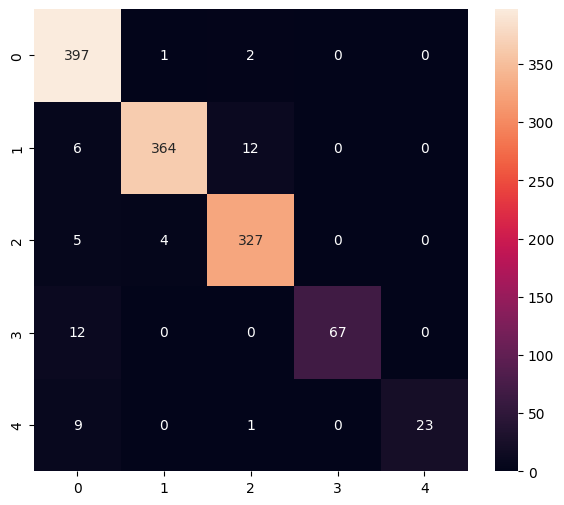

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       400
           1       0.99      0.95      0.97       382
           2       0.96      0.97      0.96       336
           3       1.00      0.85      0.92        79
           4       1.00      0.70      0.82        33

    accuracy                           0.96      1230
   macro avg       0.97      0.89      0.93      1230
weighted avg       0.96      0.96      0.96      1230



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2024-01-28 22:11:41.444949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2024-01-28 22:11:41.491471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2024-01-28 22:11:41.501513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2024-01-28 22:1

INFO:tensorflow:Assets written to: /var/folders/l0/7y17nx9n1yzgd1wwwv_sqpjc0000gn/T/tmpvntwerjf/assets


INFO:tensorflow:Assets written to: /var/folders/l0/7y17nx9n1yzgd1wwwv_sqpjc0000gn/T/tmpvntwerjf/assets
2024-01-28 22:11:43.726540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-28 22:11:43.726563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-28 22:11:43.726971: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/l0/7y17nx9n1yzgd1wwwv_sqpjc0000gn/T/tmpvntwerjf
2024-01-28 22:11:43.728034: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-01-28 22:11:43.728044: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/l0/7y17nx9n1yzgd1wwwv_sqpjc0000gn/T/tmpvntwerjf
2024-01-28 22:11:43.732453: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-01-28 22:11:43.767093: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

6588

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 243 µs, sys: 81 µs, total: 324 µs
Wall time: 336 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.9145234e-01 7.5812615e-03 5.6034303e-04 2.4320041e-05 3.8177532e-04]
0
